In [1]:
import numpy as np
import pandas as pd
import six
from random import randint
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
import keras
from sklearn.model_selection import train_test_split
from pathlib import Path
from skimage import io
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
from skimage.morphology import label
from skimage.transform import resize
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.regularizers import l2
from keras.engine.topology import Input
from keras.engine.training import Model
from keras import losses, optimizers
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.layers import Add
from distutils.version import StrictVersion
from pathlib import Path
import os
import gc
if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras_applications.imagenet_utils import _obtain_input_shape

Using TensorFlow backend.


In [2]:
data_folder = Path('/home/yuyuliao/ninja_project/data/airbus/')
masks = pd.read_csv(str(data_folder / 'train_ship_segmentations_v2.csv'))
train_path = data_folder / 'train'
valid_path = data_folder / 'test'
test_path = data_folder / 'test'
train_images_list = os.listdir(str(train_path))
test_images_list = os.listdir(str(test_path))
has_ship_data = pd.read_csv('./has_ship_data.csv')

In [3]:
masks = masks[masks['ImageId'] != '6384c3e78.jpg']

In [4]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 10
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SAMPLE'
# Downsampling inside the network
NET_SCALING = None

# Downsampling in preprocessing
IMG_SCALING = (1, 1)

# Number of validation images to use
VALID_IMG_COUNT = 400

# Maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [5]:
masks['ships'] = masks['EncodedPixels'].map(lambda row: 1 if isinstance(row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)


Using only has ship data to training the model

In [6]:
tmp_unique_img_ids = unique_img_ids[unique_img_ids['has_ship'] > 0]
tmp_unique_img_ids.shape

(42556, 4)

Use the file size to filter the data

In [ ]:
#unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda img_id: os.stat(str(train_path / img_id)).st_size/1024)
#tmp_unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50 ] # keep only greater 50 kb files


In [7]:
train_ids, valid_ids = train_test_split(tmp_unique_img_ids, 
                                        test_size=0.3, 
                                        stratify=tmp_unique_img_ids['has_ship'])

In [8]:
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print('Train images:{}'.format(train_df.shape[0]))
print('Valid images:{}'.format(valid_df.shape[0]))
del tmp_unique_img_ids
gc.collect()

Train images:57236
Valid images:24487


21

In [9]:
train_df['ships'].value_counts()



1     18993
2     10666
3      6261
4      4480
5      3240
6      2772
7      2037
8      1880
9      1494
10     1170
12     1128
11     1056
14      840
15      660
13      559
Name: ships, dtype: int64

In [10]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x + 1) // 2).clip(0, 15)

def sample_ships(in_df, base_rep_val=3000):
    if in_df['ships'].values[0] == 0:
        return in_df.sample(base_rep_val // 3)
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0] < base_rep_val))

balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df.shape

(24000, 6)

In [11]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_deconde(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x , dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def multi_rle_encode(img):
    # labels 兩個像素點如果相鄰且同值 ，則為 1 or 0；不同則反之。用來進行標記
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels > 0])]

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype=np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_deconde(mask)
    return np.expand_dims(all_masks, -1) # 在最後面延伸一個維度

In [12]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batchs = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batchs)
        for c_img_id, c_masks in all_batchs:
            rgb_path = str(train_path / c_img_id)
            c_img = io.imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values) 
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0) / 255.0, np.stack(out_mask, 0)
                out_rgb, out_mask = [], []

In [13]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


In [14]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)


(400, 768, 768, 3) (400, 768, 768, 1)


In [15]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(
    featurewise_center=False,
    samplewise_center=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    data_format='channels_last'
    )

# brightness can be problematic since it seems to change 
# the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]

image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
    
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed=202109):
    for in_x, in_y in in_gen:
        g_x = image_gen.flow(255 * in_x, 
                             batch_size=in_x.shape[0],
                             seed=seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size=in_y.shape[0],
                             seed=seed,
                             shuffle=True)
        yield next(g_x) / 255.0, next(g_y)

In [16]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (4, 768, 768, 3) float32 0.0 0.99977106
y (4, 768, 768, 1) float32 0.0 1.0


# Unet model - Decoder

Custom U-Net with Resnet34 backbone as encoder, Unet34

In [17]:
def handle_block_names_decode(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name

def Upsample2D_block(filters, stage, kernal_size=(3, 3), upsample_rate=(2, 2),
                     batch_norm=False, skip=None):
    def layer(input_tensor):
        conv_name, bn_name, relu_name, up_name = handle_block_names_decode(stage)
        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)
        print(x, skip)
        if skip is not None:
            x = Concatenate()([x, skip])
        x = Conv2D(filters, kernal_size, padding='same', name=conv_name + '1')(x)
        
        if batch_norm:
            x = BatchNormalization(name=bn_name + '1')(x)
        x = Activation('relu', name=relu_name + '1')(x)
        
        x = Conv2D(filters, kernal_size, padding='same', name=conv_name + '2')(x)
        if batch_norm:
            x = BatchNormalization(name=bn_name + '2')(x)
        x = Activation('relu', name=relu_name + '2')(x)
        return x
    return layer

def Transpose2D_block(filters, stage, kernel_size=(3, 3), upsample_rate=(2, 2),
                      transpose_kernel_size=(4, 4), batch_norm=False, skip=None):
    def layer(input_tensor):
        conv_name, bn_name, relu_name, up_name = handle_block_names_decode(stage)
        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name)(input_tensor)
        if batch_norm:
            x = BatchNormalization(name=bn_name + '1')(x)
        x = Activation('relu', name=relu_name + '1')(x)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batch_norm:
            x = BatchNormalization(name=bn_name + '2')(x)
        x = Activation('relu', name=relu_name + '2')(x)
        return x
    return layer
            

In [18]:
def build_unet(backbone, 
               classes, 
               last_block_filters, 
               skip_layers, 
               n_upsample_blocks=5,
               upsmaple_rates=(2, 2, 2, 2, 2), 
               block_type='upsampling', 
               activation='sigmoid',
               **kwargs):
    input = backbone.input
    x = backbone.output
    print(x)
    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block
    
    # Convert layer name to indices
    skip_layers = ([get_layer_number(backbone, l) if isinstance(l, str) else l 
                    for l in skip_layers])
    for i in range(n_upsample_blocks):
        # Check if there is a skip connection
        if i < len(skip_layers):
            print(backbone.layers[skip_layers[i]])
            print(backbone.layers[skip_layers[i]].output)
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsmaple_rates[i], upsmaple_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks - (i + 1))

        x = up_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)
        
    if classes < 2:
        activation = 'sigmoid'
        
    x = Conv2D(classes, (3, 3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)
    
    model = Model(input, x)
    return model
        

# ResNet34 model - encoder

In [19]:
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc' # shortcut
    return conv_name, bn_name, relu_name, sc_name

def basic_identity_block(filters, stage, block):

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

def basic_conv_block(filters, stage, block, strides=(2, 2)):
    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer

def conv_block(filters, stage, block, strides=(2, 2)):
    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)
        
        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)
        
        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)
        
        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)
        
        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x
    return layer

def identity_block(filters, stage, block):
    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)
        
        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)
        
        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x) 
        
        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x
    return layer    


In [20]:
def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid'
    }
    default_conv_params.update(params)
    return default_conv_params

def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True
    }
    default_bn_params.update(params)
    return default_bn_params
    

In [21]:
def build_resnet(repetitions=(2, 2, 2, 2), include_top=True, input_tensor=None,
                 input_shape=None, classes=1000, block_type='usual'):
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape, 
                                      default_size=224,
                                      min_size=197,
                                      data_format='channels_last',
                                      require_flatten=include_top)
    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64
    
    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = conv_block
        identity_block = identity_block
        
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x) 
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)                
            else:
                x = identity_block(filters, stage, block)(x)
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)
    
    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)
    
    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model
    
    

# Load pretrain Weight by using ImageNet trained

In [22]:
from keras.utils import get_file

def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w


def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, model.name, dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))

In [23]:
weights_collection = [
    # ResNet34
    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': True,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000.h5',
        'name': 'resnet34_imagenet_1000.h5',
        'md5': '2ac8277412f65e5d047f255bcbd10383',
    },
    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    }]

# Build Unet model base on ResNet34

In [24]:
#Freeze Encoder weight if needed

def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return

In [26]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16, 
              decoder_block_type='upsampling',
              encoder_weights=None, input_tensor=None, activation='sigmoid', **kwargs):

    backbone = build_resnet(input_tensor=None,
                            input_shape=input_shape,
                            repetitions=(3, 4, 6, 3),
                            classes=classes,
                            include_top=False,
                            block_type='basic')
    backbone.name = 'resnet34'
    
    if encoder_weights == True:
        load_model_weights(weights_collection, backbone , dataset= 'imagenet', 
                           classes = 1, include_top=False)
    
    skip_connections = list([129, 74, 37, 5]) # for resnet 34
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, block_type=decoder_block_type,
                       activation=activation, **kwargs)
    model.name = 'u-resnet34'
    
    #freeze_model(backbone)

    return model

In [27]:
seg_model = UResNet34(input_shape=(768, 768, 3), encoder_weights=True, decoder_block_type='transpose')


Tensor("relu1/Relu:0", shape=(?, 24, 24, 512), dtype=float32)
Tensor("stage4_unit1_relu1/Relu:0", shape=(?, 48, 48, 256), dtype=float32)
Tensor("stage3_unit1_relu1/Relu:0", shape=(?, 96, 96, 128), dtype=float32)
Tensor("stage2_unit1_relu1/Relu:0", shape=(?, 192, 192, 64), dtype=float32)
Tensor("relu0/Relu:0", shape=(?, 384, 384, 64), dtype=float32)


# Define Loss function

In [36]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [37]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
# https://dev.to/andys0975/what-is-dice-loss-for-image-segmentation-3p85
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred))) / (K.sum(y_true) + K.epsilon())

#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [38]:
gc.collect()

67836

In [39]:
weight_path = "{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min',
                             save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001,
                              mode='min', 
                              cooldown=2, 
                              min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience=15)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


In [40]:
from keras.utils import multi_gpu_model
isMultiGPU = 1
if isMultiGPU:
    parallel_model = multi_gpu_model(seg_model, 2)
    parallel_model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), 
                           loss=bce_logdice_loss,
                           metrics=[dice_coef, dice_loss, 'binary_accuracy'])
else:
    seg_model.compile(optimizer=optimizers.Adam(1e-4, decay=1e-6), 
                      loss=bce_logdice_loss,
                      metrics=[dice_coef, dice_loss, 'binary_accuracy'])

In [41]:
%%time
BATCH_SIZE = 32
NB_EPOCHS = 20
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0] // BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))

if isMultiGPU:
    loss_history = [parallel_model.fit_generator(aug_gen, 
                                                 steps_per_epoch=step_count,
                                                 epochs=NB_EPOCHS,
                                                 validation_data=(valid_x, valid_y),
                                                 callbacks=callbacks_list,
                                                 use_multiprocessing=False,
                                                 shuffle=True,
                                                 workers=2)]    
else:
    loss_history = [seg_model.fit_generator(aug_gen, 
                                            steps_per_epoch=step_count,
                                            epochs=NB_EPOCHS,
                                            validation_data=(valid_x, valid_y),
                                            callbacks=callbacks_list,
                                            use_multiprocessing=False,
                                            shuffle=True,
                                            workers=1)]

Epoch 1/20
200/200 [==============================] - 243s 1s/step - loss: 3.2917 - dice_coef: 0.1121 - dice_loss: 0.8548 - binary_accuracy: 0.8212 - val_loss: 1.3391 - val_dice_coef: 0.2889 - val_dice_loss: 0.6153 - val_binary_accuracy: 0.9944

Epoch 00001: val_loss improved from inf to 1.33909, saving model to seg_model_weights.best.hdf5
Epoch 2/20
200/200 [==============================] - 221s 1s/step - loss: 1.4022 - dice_coef: 0.2355 - dice_loss: 0.6816 - binary_accuracy: 0.9925 - val_loss: 1.4576 - val_dice_coef: 0.2825 - val_dice_loss: 0.6269 - val_binary_accuracy: 0.9959

Epoch 00002: val_loss did not improve from 1.33909
Epoch 3/20
200/200 [==============================] - 220s 1s/step - loss: 1.1374 - dice_coef: 0.3176 - dice_loss: 0.6109 - binary_accuracy: 0.9939 - val_loss: 0.7434 - val_dice_coef: 0.4500 - val_dice_loss: 0.4476 - val_binary_accuracy: 0.9963

Epoch 00003: val_loss improved from 1.33909 to 0.74335, saving model to seg_model_weights.best.hdf5
Epoch 4/20
200/

In [35]:
#seg_model.load_weights(weight_path)
#seg_model.save('seg_model.h5')

0

Text(0.5,1,'Dice Coef')

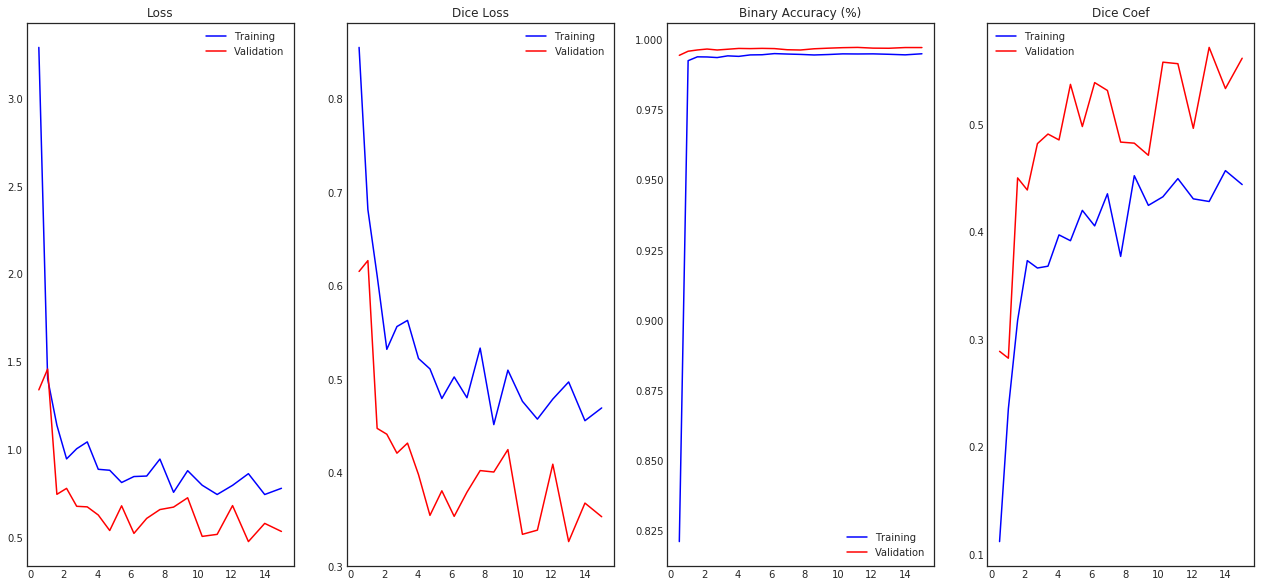

In [42]:
epich = np.cumsum(np.concatenate([np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 
             'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate([mh.history['dice_loss'] for mh in loss_history]), 
             'b-', epich, 
             np.concatenate([mh.history['val_dice_loss'] for mh in loss_history]),
             'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Dice Loss')

_ = ax3.plot(epich, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]),
             'b-', epich, 
             np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]),
             'r-')
ax3.legend(['Training', 'Validation'])
ax3.set_title('Binary Accuracy (%)')
    
_ = ax4.plot(epich, np.concatenate([mh.history['dice_coef'] for mh in loss_history]), 
             'b-', epich, 
             np.concatenate([mh.history['val_dice_coef'] for mh in loss_history]),
             'r-')
ax4.legend(['Training', 'Validation'])
ax4.set_title('Dice Coef')


In [ ]:
# Use load model method to reduce memory usage to avoid memory error

In [43]:
from keras import models, layers
#IMG_SCALING = None
if isMultiGPU:
    if IMG_SCALING is not None:
        fullres_model = models.Sequential()
        fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
        fullres_model.add(parallel_model)
        fullres_model.add(layers.UpSampling2D(IMG_SCALING))
    else:
        fullres_model = parallel_model
else:
    if IMG_SCALING is not None:
        fullres_model = models.Sequential()
        fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
        fullres_model.add(seg_model)
        fullres_model.add(layers.UpSampling2D(IMG_SCALING))
    else:
        fullres_model = seg_model
#fullres_model.save('fullres_model.h5')

In [44]:
fullres_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, None, None, 3)     0         
_________________________________________________________________
model_6 (Model)              (None, 768, 768, 1)       25675322  
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 768, 768, 1)       0         
Total params: 25,675,322
Trainable params: 25,659,956
Non-trainable params: 15,366
_________________________________________________________________


In [45]:
print(len(test_images_list), 'test images found')

15606 test images found


In [209]:
'''
import multiprocessing
def generate_test_array_data(_test_path, _img_name):
    c_path = str(_test_path / _img_name)
    c_img = io.imread(c_path)
    c_img = np.expand_dims(c_img, 0) / 255.0
    return c_img


pool_size = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=pool_size)
result = []
for c_img_name in test_images_list:
    result.append(pool.apply_async(generate_test_array_data, args=(test_path, c_img_name, )))
pool.close()
pool.join()

get_process_result = []
for res in result:
    get_process_result.append(res.get(10))
'''    

1

In [47]:
has_ship_test_images_list = has_ship_data[has_ship_data['has_ship'] > 0]['ImageId'].tolist()
len(has_ship_test_images_list)

2976

In [ ]:
%%time
from tqdm import tqdm
from skimage.morphology import binary_opening, disk
out_pred_rows = []
for c_img_name in tqdm(has_ship_test_images_list):
    c_path = str(test_path / c_img_name)
    c_img = io.imread(c_path)
    c_img = np.expand_dims(c_img, 0) / 255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg > 0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles) > 0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]
    gc.collect()

 42%|████▏     | 1258/2976 [21:32<30:06,  1.05s/it]

In [43]:
no_ship_test_images_df = pd.DataFrame()
no_ship_test_images_df['ImageId'] = has_ship_data[has_ship_data['has_ship'] == 0]['ImageId']
no_ship_test_images_df['EncodedPixels'] = None

In [44]:
from datetime import datetime
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df = pd.concat([submission_df, no_ship_test_images_df])
sub_file_name = 'submission_{}.csv'.format(datetime.now().strftime('%Y%m%d%H%M%S'))
submission_df.to_csv(sub_file_name, index=False)
submission_df.head()

,ImageId,EncodedPixels
0,d0a337b7f.jpg,366561 3 367328 5 368095 7 368864 7 369632 7 3...
1,d0a337b7f.jpg,226093 11 226860 13 227627 15 228395 15 229163...
2,d0a337b7f.jpg,27470 2 28237 5 29004 7 29771 9 30539 10 31307...
3,a5c9ae5de.jpg,467960 2 468725 7 469492 9 470259 11 471027 12...
4,a5c9ae5de.jpg,160984 6 161751 8 162518 10 163286 10 164053 1...
